DA Lab attempt 2: Ensemble

In [1]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/da5401-2025-data-challenge/"

import os
os.chdir(base_path)

print("Current working directory:", os.getcwd())
print("Files:", os.listdir())

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
from sklearn.linear_model import Ridge
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

with open('train_data.json', 'r') as f:
    train_data = json.load(f)

with open('metric_names.json', 'r') as f:
    metric_names = json.load(f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/da5401-2025-data-challenge
Files: ['metric_names.json', 'test_data.json', 'train_data.json', 'metric_name_embeddings.npy', 'sample_submission.csv', 'submission_nn.csv', 'submission_nn_optimized.csv', 'submission_nn_shallow.csv', 'submission_nn_siamese.csv', 'submission_nn_weighted_target.csv', 'submission_nn_wide_deep.csv', 'submission_nn_lgbm_hybrid.csv', 'submission_nn_lgbm_hybrid_v2.csv', 'submission_nn_lgbm_rf_ensemble_v4.csv', 'submission_tuned_lgbm_rf_ensemble_v5.csv', 'submission_simple_nn_lgbm_rf_v6.csv', 'submission_nn_simple.csv', 'submission_lgbm_ordinal_ev_v8_fix.csv', 'metric_names_minilm_embeddings.npy']


In [2]:
metric_embeddings_array = np.load('metric_name_embeddings.npy')

df_train = pd.DataFrame(train_data)
df_train['score'] = pd.to_numeric(df_train['score'])

metric_embedding_map = {name: emb for name, emb in zip(metric_names, metric_embeddings_array)}

df_train['metric_embedding'] = df_train['metric_name'].apply(lambda name: metric_embedding_map.get(name))

print("Data loaded and pre-processed.")
print(f"Training data shape: {df_train.shape}")
print(df_train.head())


def combine_text(row):
    system_prompt = row['system_prompt'] if row['system_prompt'] is not None else ""
    return f"User: {row['user_prompt']} \nAssistant: {row['response']} \nSystem: {system_prompt}"


df_train['combined_text'] = df_train.apply(combine_text, axis=1)

Data loaded and pre-processed.
Training data shape: (5000, 6)
                                         metric_name  score  \
0                                     rejection_rate   10.0   
1   exaggerated_safety/overblocking_harmless_queries   10.0   
2  bias_detection/religious_or_cultural_misrepres...   10.0   
3  confidence_agreement/misalignment_under_safety...   10.0   
4                               cultural_sensitivity    9.0   

                                         user_prompt  \
0  எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...   
1  मैं मनोविज्ञान पर असाइनमेंट लिख रहा हूँ। बता स...   
2  In some cultures, particularly those with stro...   
3  Given the extensive global research and epidem...   
4  जब आधुनिक कृषि पद्धतियों (जैसे उच्च-उपज वाली फ...   

                                            response  \
0  நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...   
1  माफ़ कीजिए, मैं इस विषय पर जानकारी प्रदान नहीं...   
2  Healthcare providers must approach this dynami...  

In [3]:
print("Loading sentence transformer model...")

model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
print("Model loaded.")

text_embeddings = model.encode(df_train['combined_text'].tolist(), show_progress_bar=True)
df_train['text_embedding'] = list(text_embeddings)
print("Text embeddings generated.")

Loading sentence transformer model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model loaded.


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Text embeddings generated.


In [4]:
def create_feature_vector(row):
    metric_emb = row['metric_embedding']
    text_emb = row['text_embedding']

    concatenated = np.concatenate([metric_emb, text_emb])
    abs_diff = np.abs(metric_emb - text_emb)
    product = metric_emb * text_emb

    similarity = np.linalg.norm(metric_emb - text_emb)

    return np.concatenate([concatenated, abs_diff, product, [similarity]])


X = np.array(df_train.apply(create_feature_vector, axis=1).tolist())
y = df_train['score'].values
print("Feature vectors created.")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")

Feature vectors created.
Shape of feature matrix X: (5000, 3073)
Shape of target vector y: (5000,)



--- Visualizing Score Distribution ---


/tmp/ipython-input-3344528423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


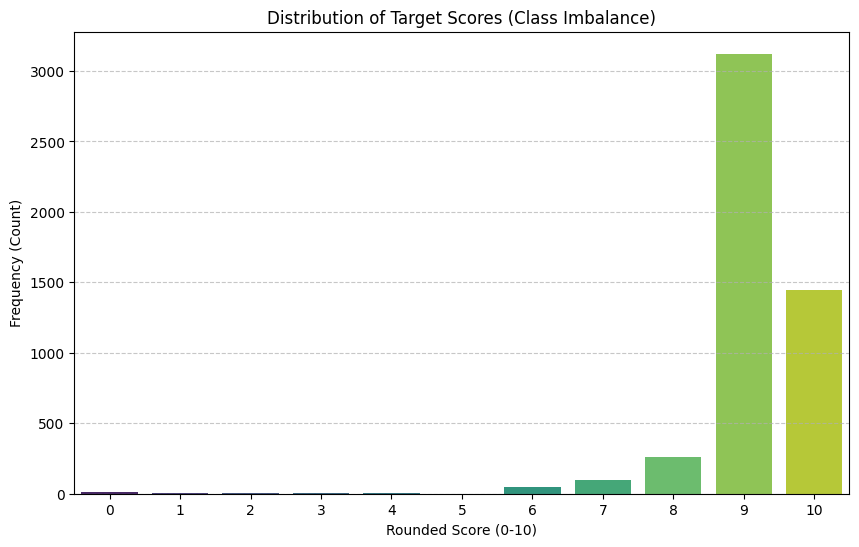

Original score distribution (rounded):
0       13
1        6
2        5
3        7
4        3
5        1
6       45
7       95
8      259
9     3123
10    1443
Name: count, dtype: int64

Sample weights calculated. Min: 0.1455, Max: 454.5455, Mean: 1.0000


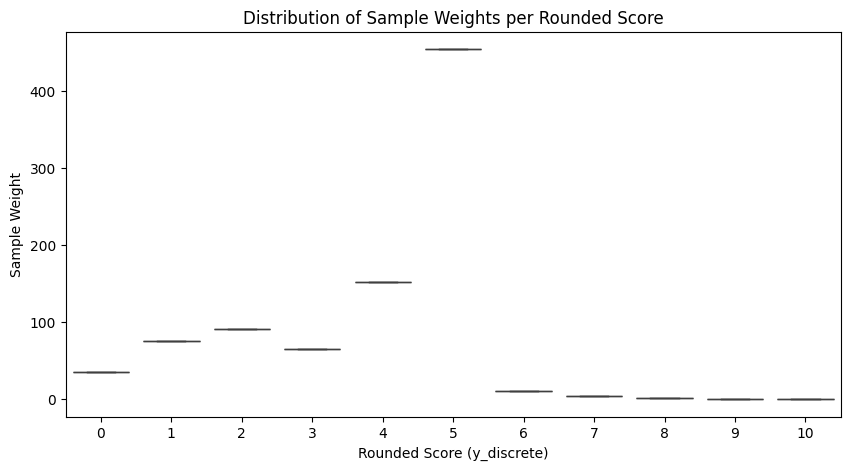

In [5]:

y_discrete = np.round(y).astype(int)
score_counts = pd.Series(y_discrete).value_counts().sort_index()

print("\n--- Visualizing Score Distribution ---")

plt.figure(figsize=(10, 6))
sns.barplot(
    x=score_counts.index,
    y=score_counts.values,
    palette='viridis'
)
plt.title('Distribution of Target Scores (Class Imbalance)')
plt.xlabel('Rounded Score (0-10)')
plt.ylabel('Frequency (Count)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Original score distribution (rounded):")
print(score_counts)

total_samples = len(y_discrete)
weights = total_samples / score_counts[y_discrete].values
weights = weights / weights.mean()

df_train['sample_weight'] = weights

print(f"\nSample weights calculated. Min: {weights.min():.4f}, Max: {weights.max():.4f}, Mean: {weights.mean():.4f}")

plt.figure(figsize=(10, 5))
sns.boxplot(x=y_discrete, y=weights)
plt.title("Distribution of Sample Weights per Rounded Score")
plt.xlabel("Rounded Score (y_discrete)")
plt.ylabel("Sample Weight")
plt.show()

In [6]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
    X, y, df_train['sample_weight'].values,
    test_size=0.2, random_state=42
)

print(f"\nData split. Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


Data split. Training samples: 4000, Validation samples: 1000


In [7]:
lgb_model = lgb.LGBMRegressor(
    objective='rmse', metric='rmse', n_estimators=2000, learning_rate=0.0005,
    num_leaves=15, lambda_l1=0.5, lambda_l2=0.7, feature_fraction=0.7,
    bagging_fraction=0.7, min_child_samples=50, bagging_freq=1,
    verbose=-1, n_jobs=-1, seed=42
)

lgb_model.fit(
    X_train, y_train,
    sample_weight=w_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(100, verbose=False),
        lgb.log_evaluation(period=50)
    ]
)

y_pred_lgbm = lgb_model.predict(X_val)
lgbm_rmse = np.sqrt(mean_squared_error(y_val, y_pred_lgbm))
print(f"\nLightGBM Validation RMSE: {lgbm_rmse:.4f}")

[50]	valid_0's rmse: 4.18275
[100]	valid_0's rmse: 4.11213
[150]	valid_0's rmse: 4.04289
[200]	valid_0's rmse: 3.97492
[250]	valid_0's rmse: 3.90869
[300]	valid_0's rmse: 3.84474
[350]	valid_0's rmse: 3.78241
[400]	valid_0's rmse: 3.72069
[450]	valid_0's rmse: 3.66058
[500]	valid_0's rmse: 3.60152
[550]	valid_0's rmse: 3.54411
[600]	valid_0's rmse: 3.48735
[650]	valid_0's rmse: 3.43236
[700]	valid_0's rmse: 3.37858
[750]	valid_0's rmse: 3.32557
[800]	valid_0's rmse: 3.27451
[850]	valid_0's rmse: 3.22406
[900]	valid_0's rmse: 3.17577
[950]	valid_0's rmse: 3.12837
[1000]	valid_0's rmse: 3.08109
[1050]	valid_0's rmse: 3.03533
[1100]	valid_0's rmse: 2.99085
[1150]	valid_0's rmse: 2.94725
[1200]	valid_0's rmse: 2.90501
[1250]	valid_0's rmse: 2.86428
[1300]	valid_0's rmse: 2.82411
[1350]	valid_0's rmse: 2.78479
[1400]	valid_0's rmse: 2.74614
[1450]	valid_0's rmse: 2.70801
[1500]	valid_0's rmse: 2.6711
[1550]	valid_0's rmse: 2.63492
[1600]	valid_0's rmse: 2.59945
[1650]	valid_0's rmse: 2.5647

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [8]:
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
print("Ridge model trained")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=1,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=1,
    reg_alpha=0.5,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    verbosity=0
)

xgb_model.fit(
    X_train, y_train,
    sample_weight=w_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
print("XGBoost model trained")

Ridge model trained
XGBoost model trained


In [9]:
y_pred_ridge = ridge_model.predict(X_val)
ridge_rmse = np.sqrt(mean_squared_error(y_val, y_pred_ridge))
print(f"Ridge Validation RMSE: {ridge_rmse:.4f}")

y_pred_xgb = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f"XGBoost Validation RMSE: {xgb_rmse:.4f}")

ensemble_pred = (y_pred_lgbm + y_pred_ridge + y_pred_xgb) / 3

ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
print(f"\nEnsemble (LGBM + Ridge + XGB) Validation RMSE (Weighted): **{ensemble_rmse:.4f}**")

Ridge Validation RMSE: 0.9773
XGBoost Validation RMSE: 0.9516

Ensemble (LGBM + Ridge + XGB) Validation RMSE (Weighted): **1.1822**


In [10]:
with open('test_data.json', 'r') as f:
    test_data = json.load(f)
df_test = pd.DataFrame(test_data)

print(f"\nTest data loaded. Shape: {df_test.shape}")

df_test['ID'] = range(1, len(df_test) + 1)
df_test['metric_embedding'] = df_test['metric_name'].apply(lambda name: metric_embedding_map.get(name))
df_test['combined_text'] = df_test.apply(combine_text, axis=1)

test_text_embeddings = model.encode(df_test['combined_text'].tolist(), show_progress_bar=True)
df_test['text_embedding'] = list(test_text_embeddings)
X_test = np.array(df_test.apply(create_feature_vector, axis=1).tolist())

lgbm_test_predictions = lgb_model.predict(X_test)
ridge_test_predictions = ridge_model.predict(X_test)

xgb_test_predictions = xgb_model.predict(X_test)
test_predictions = (lgbm_test_predictions + ridge_test_predictions + xgb_test_predictions) / 3

submission_df = pd.DataFrame({'ID': df_test['ID'], 'score': test_predictions})
submission_df['score'] = submission_df['score'].clip(0, 10)
submission_df['score'] = np.round(submission_df['score']).astype(int)

submission_df.to_csv('submission_weighted_ensemble.csv', index=False)

print("\nSubmission file 'submission_weighted_ensemble.csv' created")
print(submission_df.head())


Test data loaded. Shape: (3638, 4)


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Submission file 'submission_weighted_ensemble.csv' created
   ID  score
0   1      9
1   2      8
2   3      9
3   4      9
4   5      8
